<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingMAFExtensionGaussianLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0501 20:11:45.528966 140135473432448 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b/encoder'
!ls 

data  gdrive  ngrok  ngrok-stable-linux-amd64.zip  sample_data


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [256]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size    = 256
hidden_size   = 10
sample_size_z = 16
sigma_n       = 0.1
iaf_size      = [[512, 512], [512, 512], [512, 512], [512, 512]]

sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

generator = hub.Module(generator_path, trainable=False)
encoder   = hub.Module(encoder_path, trainable=False)

# Define latent space prior
prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
log_det_prior     = tf.linalg.logdet(prior.covariance())

# define latent space posterior


# get some masked data
x_corr            = tf.placeholder(shape=[batch_size,784,1], dtype=tf.float32)
prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)

encoded_data      = encoder(tf.reshape(x_corr,[-1,28,28,1]))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)

sigma             = tf.nn.softplus(sigma) + 0.0001
approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,1])
#vae_liklogits     = tf.boolean_mask(vae_liklogits, mymask, axis=1)

# training data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
#naive_sims        = likelihood_vae.sample(sample_size_x)
naive_mean        = likelihood_vae.mean()

# test saple from prior
prior_samples     = prior.sample(sample_size_z)


sample_liklogits  = tf.reshape(generator(prior_sample),[-1,784,1])
sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()



p1 = permutation(hidden_size)
chain = tfb.Chain([tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512])),tfb.Permute(permutation=p1),\
                   tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512]))])
maf = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(loc=np.zeros(hidden_size, dtype='float32'),scale_identity_multiplier=1.0),bijector=chain)


shape1 = tf.shape(tf.reshape(encoded_data,[batch_size, hidden_size,-1]))
#maximizing probablity of encoded data to train the MAF (re-fitting the posterior)
loss = -tf.reduce_mean(maf.log_prob(approx_posterior.sample()))

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op    = optimizer.minimize(loss)

shape = tf.shape(encoded_data)
print(maf)
maf_samples       = maf.sample(sample_size_z)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0501 23:05:13.900736 140135473432448 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0501 23:05:13.952745 140135473432448 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0501 23:05:14.032593 140135473432448 saver.py:1483] Saver not created because there are no variables in the graph to restore


tfp.distributions.TransformedDistribution("chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowMultivariateNormalDiag_4/", batch_shape=(), event_shape=(10,), dtype=float32)


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

In [259]:
sess.run([shape,shape1], feed_dict={x_corr: np.expand_dims(x_truth,-1)})

[array([256,  20], dtype=int32), array([256,  10,   2], dtype=int32)]

(16, 784, 1)


<Figure size 360x360 with 0 Axes>

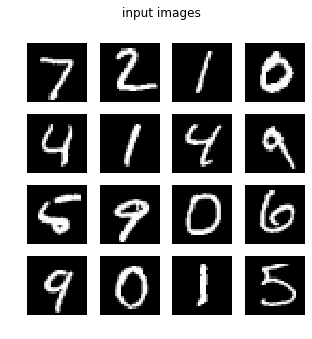

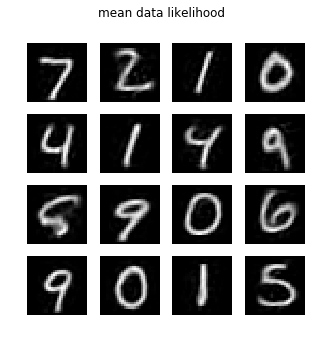

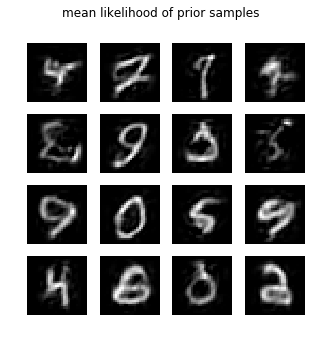

In [260]:
samples = sess.run(prior_samples, feed_dict={x_corr: np.expand_dims(x_truth,-1)})
samples.shape
inim, res, s = sess.run([x_corr,naive_mean,sample_mean], feed_dict={x_corr: np.expand_dims(x_truth,-1), prior_sample: samples})
figure(figsize=(5,5))
print(s.shape)
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean likelihood of prior samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss=[]
ii     = 0
nepoch = 0

In [268]:
while nepoch<20:
  if (ii+1)*batch_size>len(x_train): 
    ii=0
    nepoch+=1
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_corr: np.expand_dims(x_truth,-1), lr: 1e-3})
  posterior_loss+=[ll]
  if ii%100==0:
    print(ll)
  ii+=1

9.293104
9.349862
9.264206
9.334102
9.272295
9.313004
9.212481
9.340698
9.185905
9.302641
9.1716585
9.299353
9.176502
9.256309
9.156387
9.240431
9.081796
9.251032
9.145981
9.224609
9.08559
9.225632
9.026583
9.23214
9.051509
9.255462
9.059654
9.175193
9.006302
9.198843
8.993753
9.177535
9.020207
9.120441
9.016989
9.173844
9.008871
9.130959
8.954817
9.148386
8.991523


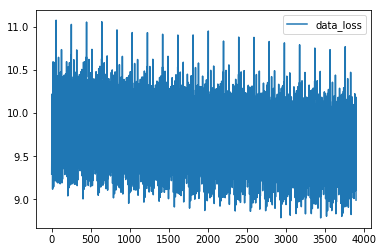

In [269]:
plt.figure()
plot(posterior_loss,label='data_loss')
legend()

<Figure size 360x360 with 0 Axes>

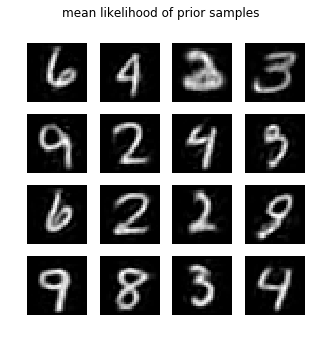

In [270]:
samples = sess.run(maf_samples, feed_dict={x_corr: np.expand_dims(x_truth,-1)})
samples.shape
s = sess.run(sample_mean, feed_dict={x_corr: np.expand_dims(x_truth,-1), prior_sample: samples})
figure(figsize=(5,5))


figure(figsize=(5,5))
suptitle('mean likelihood of prior samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

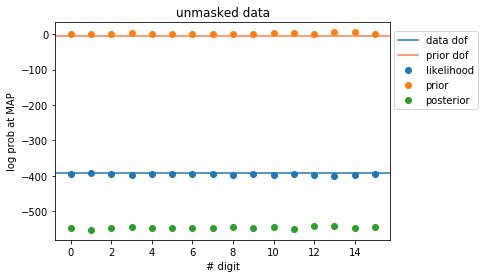

In [0]:
prior_MAP_corr, likeli_corr_MAP_, post_corr_MAP_ = sess.run([ppMAP,ni_likeli_corr_MAP, posterior_corr_MAP], feed_dict={x_corr: x_truth_sigma})
likeli_corr_MAP_= -np.sum(likeli_corr_MAP_,axis=1)
plt.figure()
plt.title('unmasked data')
plt.axhline(-28*28/2., label='data dof')
plt.axhline(-10/2., label='prior dof', color='coral')
plt.plot(np.arange(len(prior_MAP_)), likeli_corr_MAP_, ls='', marker='o', label='likelihood')
plt.plot(np.arange(len(prior_MAP_)), prior_MAP_corr, ls='', marker='o',label='prior')
plt.plot(np.arange(len(prior_MAP_)), post_corr_MAP_, ls='', marker='o',label='posterior')
plt.xlabel('# digit')
plt.ylabel('log prob at MAP')
plt.legend(loc=(1.01,0.6))
plt.show()

563.6068
553.09326
550.7906
549.5756
548.89685
548.4778
548.17444
547.9592
547.786
547.56396
547.43945
547.33105
547.23956
547.19336
547.17847
547.1189
547.05884
547.03485
547.0017
546.9829
546.9775
546.9696
546.9592
546.9554
546.9541
546.954
546.95386
546.95386
546.95386
546.954
546.95386
546.9539
546.95386
546.9539
546.95386
546.954
546.9539
546.95386
546.954
546.9539
546.95386
546.95386
546.95386
546.9539
546.9539


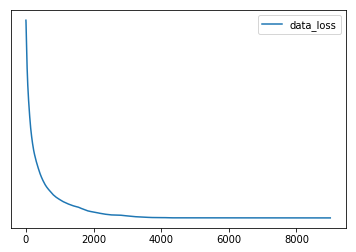

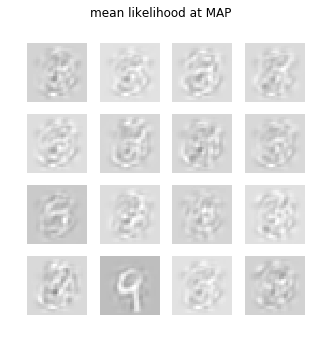

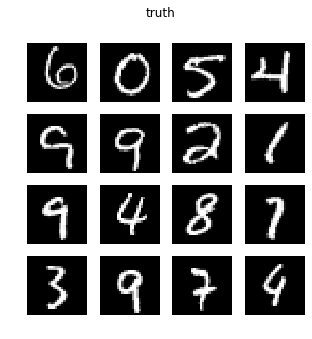

In [0]:
#same things, starting minimization from some point -> getting stuck at different point
posterior2_loss=[]
ini = np.reshape(np.random.randn((batch_size*hidden_size)),[batch_size,hidden_size])
sess.run(MAP_reset,feed_dict={x_corr: x_truth_sigma, MAP_ini:ini})
lrate=1e-1
for ii in range(2000):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: x_truth_sigma, MAP_ini:ini})
  posterior2_loss.append(ll)
  if ii%200==0:
    print(ll)
lrate=1e-3
for ii in range(5000):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: x_truth_sigma, MAP_ini:ini})
  posterior2_loss.append(ll)
  if ii%200==0:
    print(ll)
lrate=1e-5
for ii in range(2000):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: x_truth_sigma, MAP_ini:ini})
  posterior2_loss.append(ll)
  if ii%200==0:
    print(ll)
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

xrecons= sess.run(MAP_mean,feed_dict={x_corr: x_truth_sigma, MAP_ini:ini})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth_sigma[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

[[0.21963772]
 [0.22391616]
 [0.22035632]
 [0.22523744]
 [0.22733077]
 [0.22660556]
 [0.21659264]
 [0.23506819]
 [0.22700569]
 [0.23152441]
 [0.22385451]
 [0.23400588]
 [0.22703688]
 [0.22257519]
 [0.23351657]
 [0.23112778]]


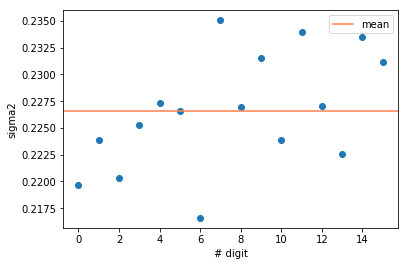

In [0]:
#getting sigma^2 (do this for unmasked data -> this is the model error -> but i dont have access to it for this set of numbers!)
model = sess.run(MAP_mean,feed_dict={x_corr: x_truth_sigma})
sigma2 = np.mean((model.reshape(x_truth_sigma.shape)-x_truth_sigma)**2,axis=1)

print(sigma2)
plt.figure()
plt.plot(np.arange(len(sigma2)),sigma2, ls='',marker='o')
plt.axhline(np.mean(sigma2), label='mean', c='coral')
plt.ylabel('sigma2')
plt.xlabel('# digit')
plt.legend()
plt.show()

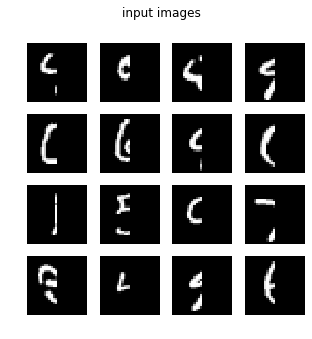

In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,14:28]=0.
mask = mask.reshape((28*28))

masked_data = np.expand_dims(x_test[inc:batch_size+inc]*[mask],-1)

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    if batch_size<16:
      subplot(1,batch_size,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

<Figure size 360x360 with 0 Axes>

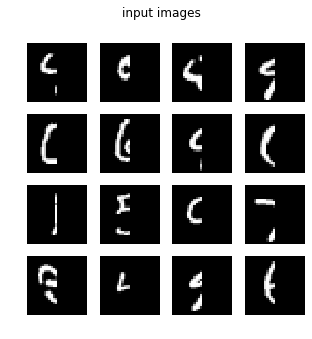

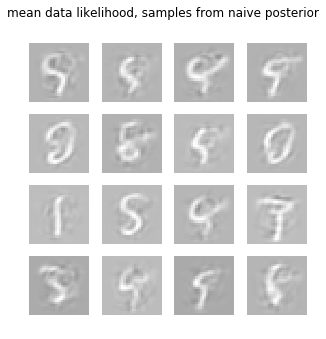

In [0]:
inim, res = sess.run([x_corr,naive_mean],feed_dict={x_corr: masked_data, mymask:mask})


figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood, samples from naive posterior')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],[28,28]),cmap='gray',vmin=0); #colorbar()
    axis('off')



In [0]:
posterior2_loss=[]
ini = np.zeros((batch_size,hidden_size), dtype=np.float)
_ = sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})

In [0]:
lrate=1e-1
for ii in range(300):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-3
for ii in range(800):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-5
for ii in range(800):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)

278.5901
277.18457
277.18918
277.17242
277.1363
277.13354
277.1328
277.13257
277.13245
277.13245
277.13245
277.13245
277.1322
277.13217
277.13217
277.13217
277.13214
277.13217
277.13217


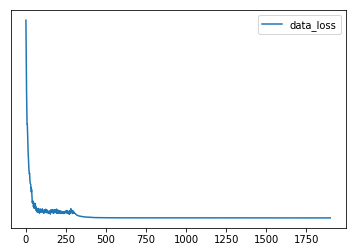

In [0]:
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

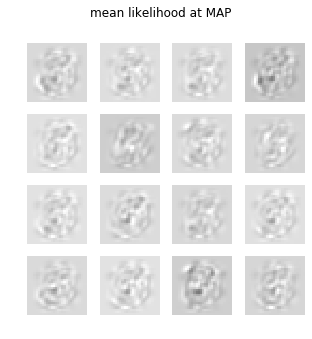

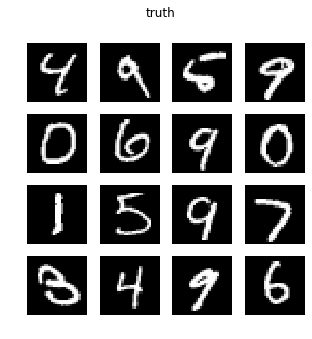

In [0]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size,16)):
#     if batch_size<16:
#       subplot(1,batch_size,i+1)
#       imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#       axis('off')
#     else:
    subplot(4,4,i+1)
    imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

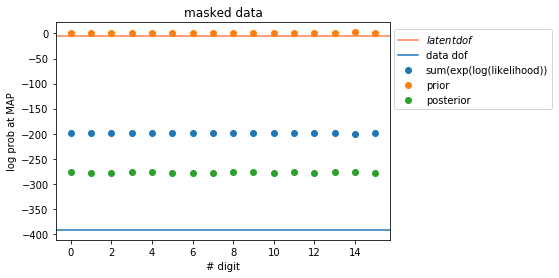

In [0]:
prior_MAP_, likeli_corr_MAP_, post_corr_MAP_ = sess.run([ppMAP,ni_likeli_corr_MAP, posterior_corr_MAP], feed_dict={x_corr:masked_data, mymask: mask})
likeli_corr_MAP_= -np.sum(likeli_corr_MAP_,axis=1)
plt.figure()
plt.title('masked data')
plt.axhline(-hidden_size/2, label='$latent dof$', color='coral')
plt.axhline(-np.sum(mask), label='data dof')
plt.plot(np.arange(len(prior_MAP_)), likeli_corr_MAP_, ls='', marker='o', label='sum(exp(log(likelihood))')
plt.plot(np.arange(len(prior_MAP_)), prior_MAP_, ls='', marker='o',label='prior')
plt.plot(np.arange(len(prior_MAP_)), post_corr_MAP_, ls='', marker='o',label='posterior')
plt.xlabel('# digit')
plt.ylabel('log prob at MAP')
plt.legend(loc=(1.01,0.6))
plt.show()

In [0]:
_=sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

In [0]:
_=sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

(64, 16, 784)


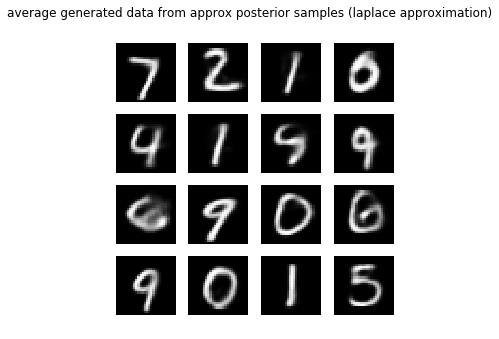

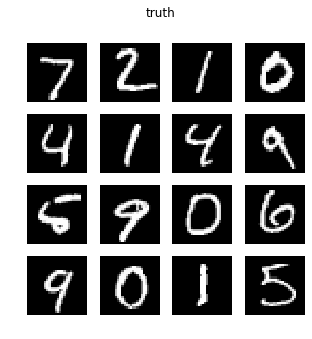

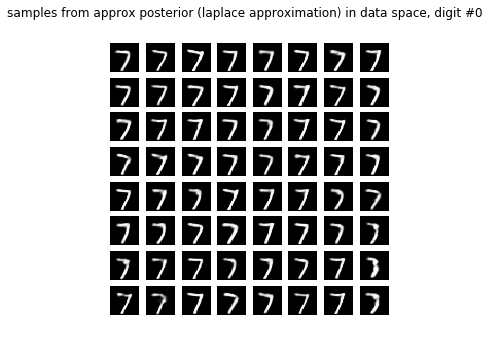

In [0]:
xrecons3 = sess.run(new_x_mean, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
print(xrecons3.shape)
# xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, sample_size:64, mymask: mask})
# print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (laplace approximation)')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('samples from approx posterior (laplace approximation) in data space, digit #%d'%inc)
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(xrecons3[jj,0].reshape((28,28)),cmap='gray',vmin=0); 
  axis('off')
 
      

In [0]:
minima=[]
min_loss=[]
n_samples=20
for jj in range(n_samples):
  print(jj)
  ini = np.random.randn(batch_size,hidden_size)*5
  sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})
  for lrate,num in zip([1e-1,1e-2, 1e-3, 1e-5],[300,400,1000,1000]):
    for ii in range(num):
      _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  minima+=[sess.run(MAP,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})]
  min_loss+=[ll]

0
1


KeyboardInterrupt: ignored

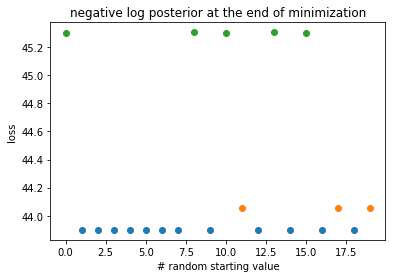

In [0]:
min_loss = np.asarray(min_loss)
index1 = np.where(min_loss<44)
# index3 = np.where((min_loss>60)*(min_loss<90))
index3 = np.where(min_loss>45)
index2 = np.where((min_loss>44)*(min_loss<44.2))
x = np.arange(n_samples)
plt.figure()
plt.title('negative log posterior at the end of minimization')
plt.plot(x[index1],min_loss[index1], ls='', marker='o')
plt.plot(x[index2],min_loss[index2], ls='', marker='o')
plt.plot(x[index3],min_loss[index3], ls='', marker='o')
plt.plot(x[index4],min_loss[index4], ls='', marker='o')
#plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# random starting value')
plt.ylabel('loss')
plt.show()

W0425 23:41:01.395235 140369430304640 legend.py:1289] No handles with labels found to put in legend.


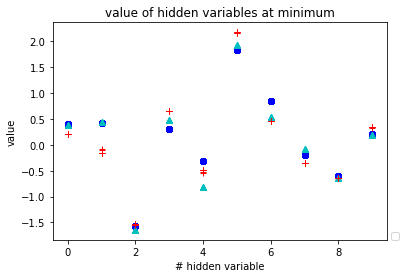

In [0]:
minima = np.asarray(minima)
plt.figure()
plt.title('value of hidden variables at minimum')
for index, color, m in zip([index1, index2, index3],['b','c','r','coral'], ['o','^','+','*']):
  for ii in index[0]:
    plt.plot(np.arange(hidden_size),minima[ii,0,:], ls='', marker=m, color=color)
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

assuming there are four distinct minima in this case

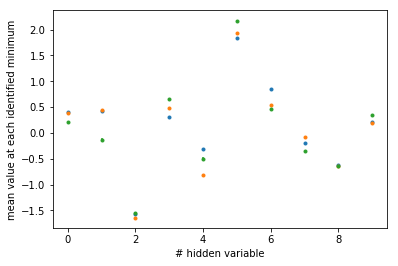

In [0]:
mus = []
std_mus = []
for index in [index1, index2, index3]:
  mus+=[np.mean(minima[index], axis=0)]
  std_mus+=[np.std(minima[index], axis=0)]

mus    =np.asarray(mus)
std_mus=np.asarray(std_mus)
plt.figure()
for ii in range(num_comp):
  plt.errorbar(np.arange(hidden_size),mus[ii][0], yerr=std_mus[ii][0], ls='', marker='.')
plt.xlabel('# hidden variable')
plt.ylabel('mean value at each identified minimum')
plt.show()

get covariances at these three minima to build Gaussian mixture model

[[ 0.40390995  0.4160454  -1.5684832   0.30107045 -0.30964944  1.8302697
   0.85153013 -0.19617684 -0.61166984  0.20230508]]
[-43.89909] [6.176446]
[[ 0.37605986  0.4391946  -1.6448692   0.48621526 -0.8209117   1.937256
   0.5380141  -0.0783013  -0.64512414  0.19004709]]
[-44.058075] [6.1381893]
[[ 0.21612899 -0.1290344  -1.5402281   0.6559146  -0.50232184  2.1725245
   0.4639402  -0.35683113 -0.636465    0.3449269 ]]
[-45.305782] [4.9137125]
[[1.7884283e-22]
 [1.5850340e-22]
 [1.5486416e-22]]
[0.36334634 0.3220237  0.31463003]


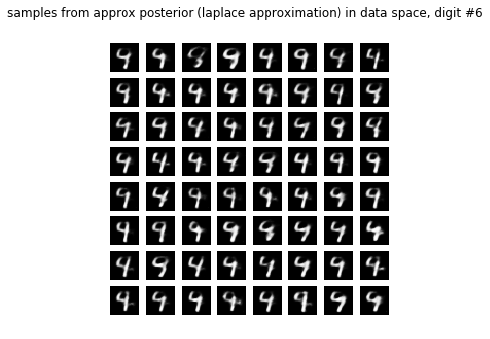

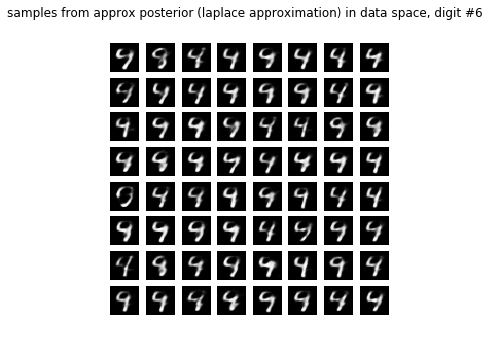

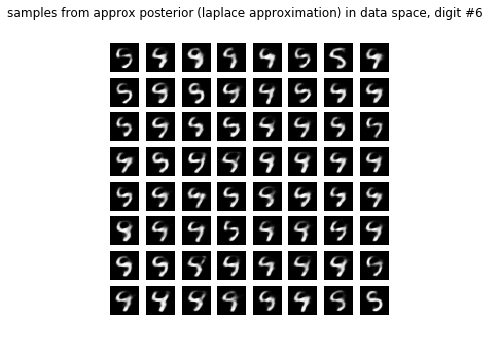

In [0]:
mu_=[]
sigma_=[]
w_tilde=[]
diag=[]
for ii in range(num_comp):
  print(sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:mus[ii]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  xrecons3 = sess.run(new_x_mean, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
  figure(figsize=(5,5))
  suptitle('samples from approx posterior (laplace approximation) in data space, digit #%d'%inc)
  for jj in range(64):   
    subplot(8,8,jj+1)
    imshow(xrecons3[jj,0].reshape((28,28)),cmap='gray',vmin=0); 
    axis('off')
  diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_=sess.run(log_det,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  logprob_lap, logprob = sess.run([lapl_log_prob_MAP,posterior_corr_MAP],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  w_tilde+=[np.exp(0.5*logdet_+logprob)]
  #same as
  #w_tilde+=[np.exp(-logprob_lap+logprob)]
  print(logprob, logprob_lap)
mu_    = np.asarray(mu_)
sigma_ = np.asarray(sigma_)

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


In [0]:
print(logdet_)

[array([-30.731663], dtype=float32), array([-30.65515], dtype=float32), array([-28.206196], dtype=float32)]


In [0]:
diag=np.asarray(diag)
diag.shape

(3, 1, 10)

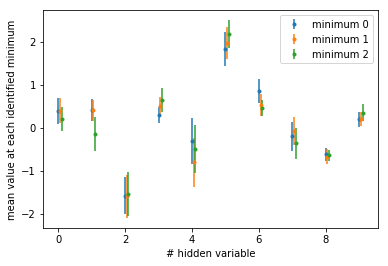

In [0]:
mus = []
std_mus = []
for index in [index1, index2, index3]:
  mus+=[np.mean(minima[index], axis=0)]
  std_mus+=[np.std(minima[index], axis=0)]

mus    =np.asarray(mus)
std_mus=np.asarray(std_mus)
plt.figure()
for ii in range(num_comp):
  plt.errorbar(np.arange(hidden_size)+ii*0.05,mus[ii][0], yerr=np.sqrt(diag[ii][0]), ls='', marker='.',label='minimum %d'%ii)
plt.xlabel('# hidden variable')
plt.ylabel('mean value at each identified minimum')
plt.legend()
plt.show()

In [0]:
w=[]
#choosing weights from how often I land in this minimum?
for index in [index1, index2, index3]:
  w+=[len(index[0])/n_samples]
w=np.asarray(w)
print(sum(w),w)


1.0 [0.45 0.3  0.25]


In [0]:
sigma_=sigma_.reshape(batch_size,num_comp,hidden_size,hidden_size)
mu_=mu_.reshape(batch_size,num_comp,hidden_size)

In [0]:
_= sess.run(gmm_sample_x,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_= sess.run(update_a,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })

In [0]:
#sess.run(print(gmm.parameters),feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })

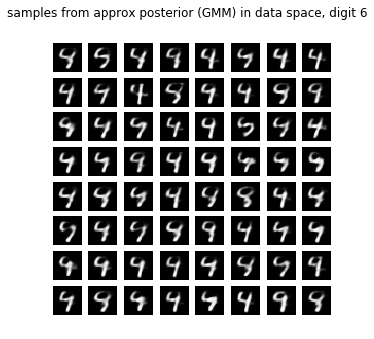

In [0]:
x_recons = sess.run(gmm_sample_x,feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})

num = 6
figure(figsize=(5,5))
suptitle('samples from approx posterior (GMM) in data space, digit %d'%num)
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(x_recons[jj,0,:].reshape((28,28)),cmap='gray',vmin=0); 
  axis('off')

In [0]:
posterior3_loss=[]

In [0]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-8
for ii in range(1000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)

125.43983
53.972427
51.095417
52.852158
52.220303
51.745453
59.79688
55.41687
48.886444
50.290237
50.705467
47.86161
51.23502
48.224148
52.202114
50.274364
53.394047
55.747158
57.70546
54.788666
51.10123
54.316017
55.443016
50.435104
54.1687
48.934147
51.920067
49.782227
51.653595
46.90789
53.275257
49.099495
48.620316
57.055885
50.92048
50.751114
49.366768
51.398243
49.64446
50.181084


In [0]:
sess.run([tf.reduce_mean(posterior_corr_elbo),posterior_corr_MAP],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

[-48.52991, array([-45.299267], dtype=float32)]

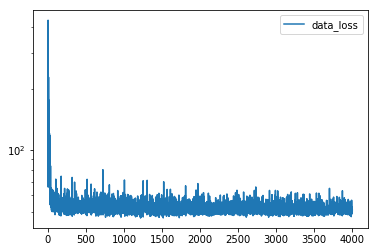

In [0]:
plot(posterior3_loss,label='data_loss')
legend()
yscale('log')

(64, 1, 784)


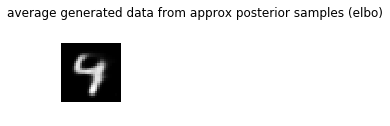

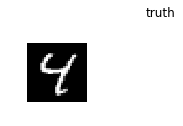

In [0]:
xrecons3 = sess.run(x_mean_elbo, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
print(xrecons3.shape)
# xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, sample_size:64, mymask: mask})
# print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (elbo)')
for i in range(min(batch_size,16)):
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
      axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')